<a href="https://colab.research.google.com/github/Sampreeth3217/LoanDefaulter/blob/main/LoanDefaulter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving Default_Fin.csv to Default_Fin (1).csv
Dataset Shape: (10000, 5)


,Index,Employed,Bank Balance,Annual Salary,Defaulted?
0,1,1,8754.36,532339.56,0
1,2,0,9806.16,145273.56,0
2,3,1,12882.60,381205.68,0
3,4,1,6351.00,428453.88,0
4,5,1,9427.92,461562.00,0


Numeric Features: ['Employed', 'Bank Balance', 'Annual Salary']
Categorical Features: []
[Logistic Regression] Best Params: {'clf__C': 3.0, 'clf__solver': 'lbfgs'}
[Logistic Regression] Best CV ROC-AUC: 0.9494
[Random Forest] Best Params: {'clf__max_depth': 10, 'clf__min_samples_leaf': 3, 'clf__n_estimators': 200}
[Random Forest] Best CV ROC-AUC: 0.9319

=== Logistic Regression Test Metrics ===
ROC-AUC: 0.9487 | PR-AUC: 0.5238

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.85      0.92      1933
           1       0.17      0.88      0.29        67

    accuracy                           0.85      2000
   macro avg       0.58      0.87      0.60      2000
weighted avg       0.97      0.85      0.90      2000

Confusion Matrix:
 [[1651  282]
 [   8   59]]


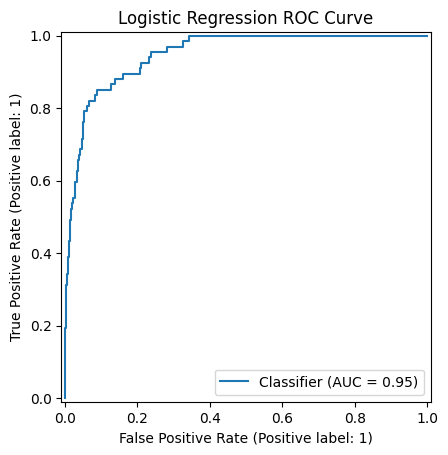

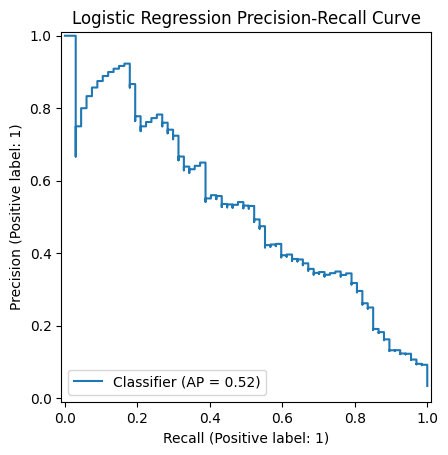

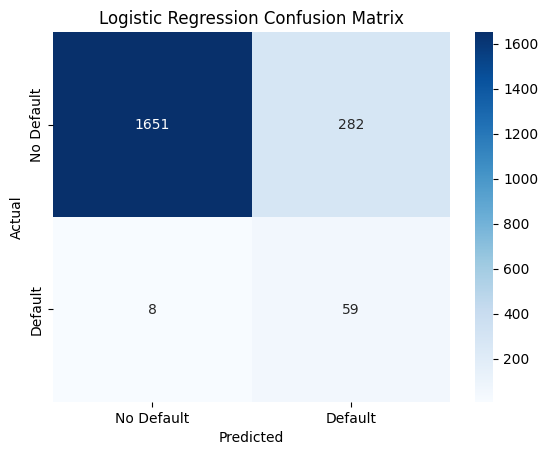


=== Random Forest Test Metrics ===
ROC-AUC: 0.9302 | PR-AUC: 0.4777

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.94      0.97      1933
           1       0.29      0.66      0.40        67

    accuracy                           0.94      2000
   macro avg       0.64      0.80      0.68      2000
weighted avg       0.96      0.94      0.95      2000

Confusion Matrix:
 [[1826  107]
 [  23   44]]


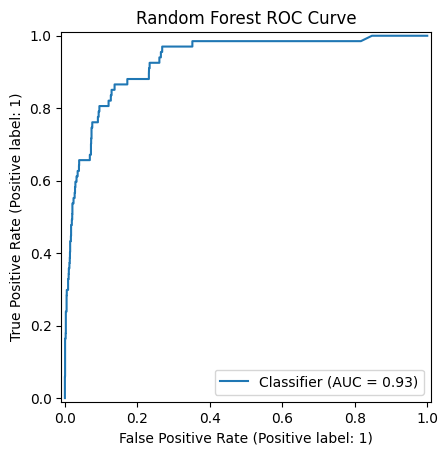

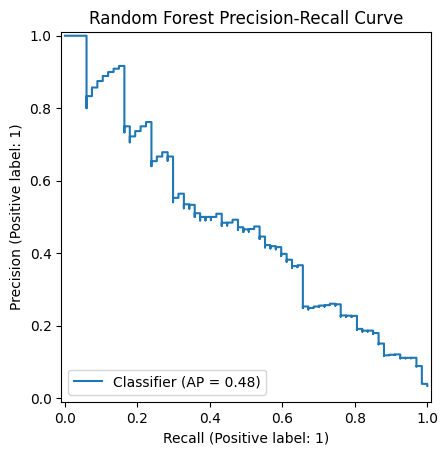

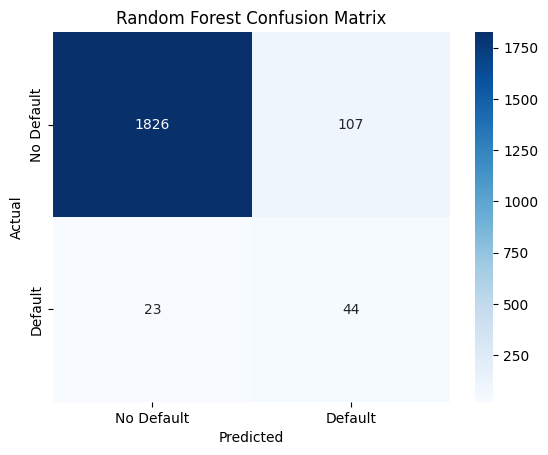


✅ Best model selected: Logistic Regression
📂 Best model saved as best_loan_model.joblib

Demo Prediction:
      Employed  Bank Balance  Annual Salary
8354         1      11893.92      513212.28
Predicted Default Probability: 0.156
Predicted Label: No Default


In [2]:
# ==========================================
# 📌 Bank Loan Default Prediction (Colab)
# ==========================================

# 1) Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, classification_report,
    confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
)

# ==========================================
# 2) Upload Dataset (Colab)
# ==========================================
from google.colab import files
uploaded = files.upload()

# Assume uploaded file is Default_Fin.csv
df = pd.read_csv(next(iter(uploaded)))
print("Dataset Shape:", df.shape)
display(df.head())

# ==========================================
# 3) Features & Target
# ==========================================
# Adjust target column name if needed
df = df.drop(columns=["Index"])

# Correct target column
target_col = "Defaulted?"

# Identify features
numeric_features = df.select_dtypes(include=["int64", "float64"]).columns.drop(target_col).tolist()
categorical_features = df.select_dtypes(include=["object"]).columns.tolist()

print("Numeric Features:", numeric_features)
print("Categorical Features:", categorical_features)

X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ==========================================
# 4) Preprocessing
# ==========================================
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# ==========================================
# 5) Models
# ==========================================
log_reg = LogisticRegression(max_iter=2000, class_weight="balanced")
rf = RandomForestClassifier(class_weight="balanced", random_state=42)

pipe_lr = Pipeline(steps=[("prep", preprocessor), ("clf", log_reg)])
pipe_rf = Pipeline(steps=[("prep", preprocessor), ("clf", rf)])

param_grid_lr = {
    "clf__C": [0.1, 1.0, 3.0],
    "clf__solver": ["lbfgs", "liblinear"]
}
param_grid_rf = {
    "clf__n_estimators": [200, 400],
    "clf__max_depth": [None, 10, 20],
    "clf__min_samples_leaf": [1, 3, 5]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ==========================================
# 6) Grid Search
# ==========================================
def run_search(pipe, grid, name):
    gs = GridSearchCV(
        estimator=pipe,
        param_grid=grid,
        scoring="roc_auc",
        cv=cv,
        n_jobs=-1
    )
    gs.fit(X_train, y_train)
    print(f"[{name}] Best Params:", gs.best_params_)
    print(f"[{name}] Best CV ROC-AUC: {gs.best_score_:.4f}")
    return gs

gs_lr = run_search(pipe_lr, param_grid_lr, "Logistic Regression")
gs_rf = run_search(pipe_rf, param_grid_rf, "Random Forest")

# ==========================================
# 7) Evaluation Function
# ==========================================
def evaluate(model, name):
    proba = model.predict_proba(X_test)[:, 1]
    preds = (proba >= 0.5).astype(int)

    roc = roc_auc_score(y_test, proba)
    pr = average_precision_score(y_test, proba)

    print(f"\n=== {name} Test Metrics ===")
    print(f"ROC-AUC: {roc:.4f} | PR-AUC: {pr:.4f}")
    print("\nClassification Report:\n", classification_report(y_test, preds))
    print("Confusion Matrix:\n", confusion_matrix(y_test, preds))

    # ROC Curve
    RocCurveDisplay.from_predictions(y_test, proba)
    plt.title(f"{name} ROC Curve")
    plt.show()

    # Precision-Recall Curve
    PrecisionRecallDisplay.from_predictions(y_test, proba)
    plt.title(f"{name} Precision-Recall Curve")
    plt.show()

    # Confusion Matrix Heatmap
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Default", "Default"], yticklabels=["No Default", "Default"])
    plt.title(f"{name} Confusion Matrix")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

evaluate(gs_lr.best_estimator_, "Logistic Regression")
evaluate(gs_rf.best_estimator_, "Random Forest")

# ==========================================
# 8) Select Best Model
# ==========================================
auc_lr = roc_auc_score(y_test, gs_lr.best_estimator_.predict_proba(X_test)[:,1])
auc_rf = roc_auc_score(y_test, gs_rf.best_estimator_.predict_proba(X_test)[:,1])

best_model = gs_lr.best_estimator_ if auc_lr >= auc_rf else gs_rf.best_estimator_
best_name = "Logistic Regression" if best_model == gs_lr.best_estimator_ else "Random Forest"
print(f"\n✅ Best model selected: {best_name}")

# ==========================================
# 9) Feature Importance (for RF only)
# ==========================================
if best_name == "Random Forest":
    # Get feature names after preprocessing
    ohe = best_model.named_steps["prep"].named_transformers_["cat"]["ohe"]
    cat_names = ohe.get_feature_names_out(categorical_features)
    feature_names = numeric_features + list(cat_names)

    importances = best_model.named_steps["clf"].feature_importances_
    feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

    plt.figure(figsize=(10,6))
    sns.barplot(x=feat_imp.values[:15], y=feat_imp.index[:15])
    plt.title("Top 15 Feature Importances")
    plt.show()

# ==========================================
# 10) Save Best Model
# ==========================================
joblib.dump(best_model, "best_loan_model.joblib")
print("📂 Best model saved as best_loan_model.joblib")

# ==========================================
# 11) Demo Prediction
# ==========================================
# Pick a sample row from test set
sample = X_test.iloc[[0]]
prob = best_model.predict_proba(sample)[:,1][0]
print("\nDemo Prediction:")
print(sample)
print("Predicted Default Probability:", round(prob, 4))
print("Predicted Label:", "Default" if prob>=0.5 else "No Default")
